# Стратегия взаимодействия с клиентами сети фитнес-центров «Культурист-датасаентист»

Цель: 

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

## Загрузка данных

In [1]:
import pandas as pd # импортируем библиотеки
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from warnings import simplefilter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Набор данных включает следующие поля:

* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

## Проведение исследовательского анализа данных (EDA)

### Посмотрите на датасет: есть ли в нём отсутствующие значения (пропуски), изучите средние значения и стандартные отклонения (пригодится метод describe());

In [6]:
data.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [7]:
data.columns = data.columns.str.lower() # приводим названия столбцов к нижнему регистру

In [8]:
data.duplicated().sum() # явных дупликатов нет

0

In [9]:
data.describe().T # средние значения и стандартные отклонения

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Пропусков и повторов (явных) нет, соответственно, будем работать со всеми данными. Из выводов - в среднем, посетитель фитнес-зала - в 84% случаях живет неподалеку, в 48% случаях является сотрудником компании-партнёра клуба, в 30% спользовал промо-код от знакомого при оплате первого абонемента, в 90% оставил свой контактный телефон, оплатил абонемент на 4.6 месяцев, ему 29 лет, до конца абонемента осталось 4.3 месяца, посещает зал в течение 3.7 месяцев, покинул спортзал в этом месяце в 27% случаях.

### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());

In [10]:
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Разделим датафрейм на две части - оставшихся в спортзале и покинувших в текущем месяце. Из различий между двумя получившимися группами - оставшиеся чаще живут ближе, являются сотрудниками компании-партнера клуба, используют промокоды от друзей при первом посещении, посещают групповые занятия, тратят больше денег на другие услуги, чаще посещают спортзал. Судя по показателям `lifetime`, `contract_period` и `month_to_end_contract` можно предположить, что ушедшие занимались недолго, у них были краткосрочные абонементы, которые они не стали приобретать. Возможно, причина в том, что занимались в одиночку и потеряли интерес. 

### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

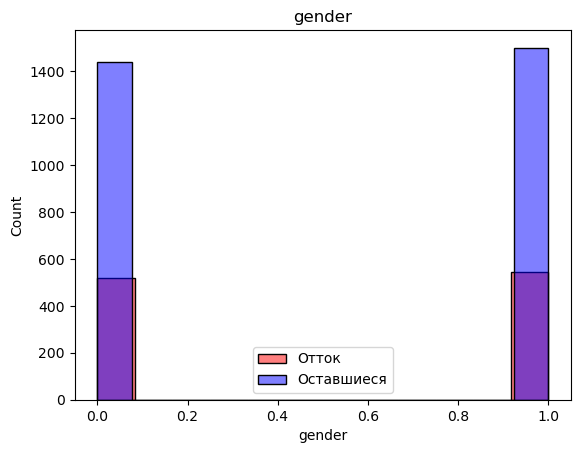

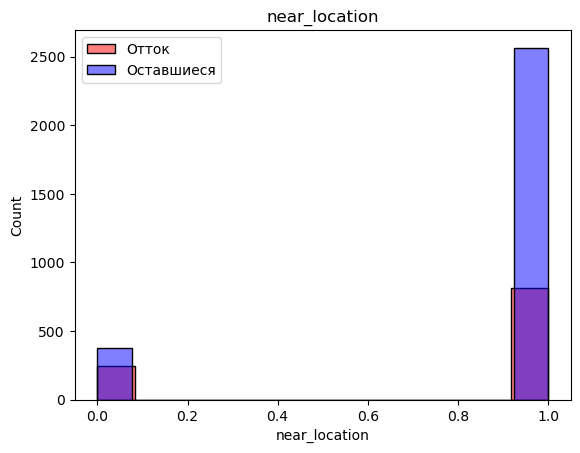

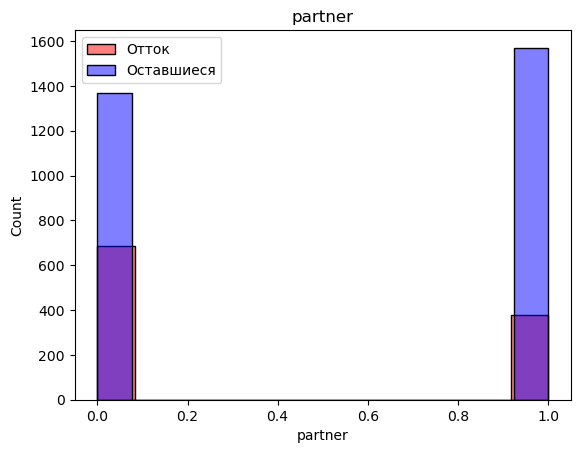

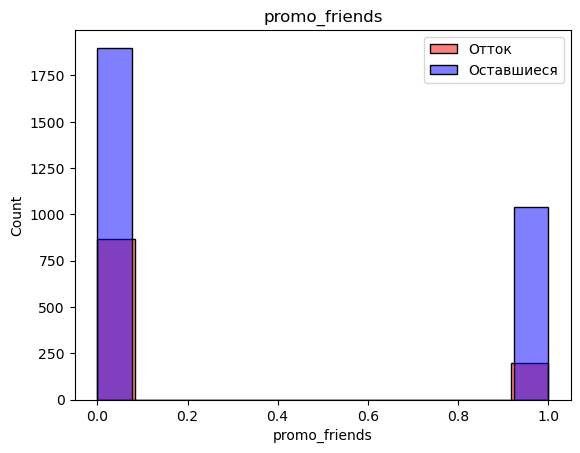

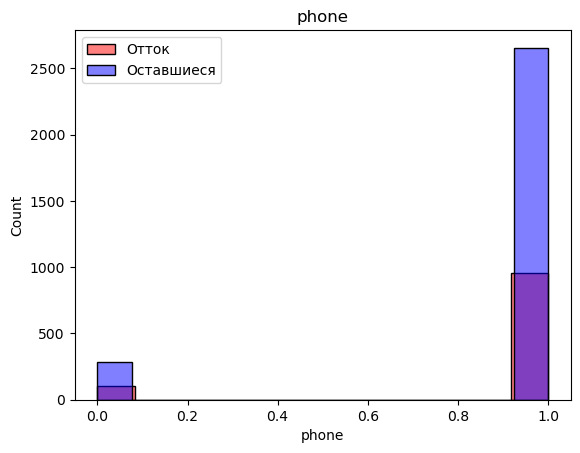

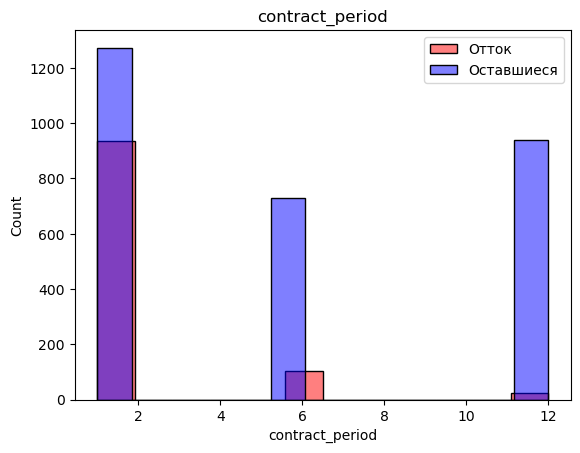

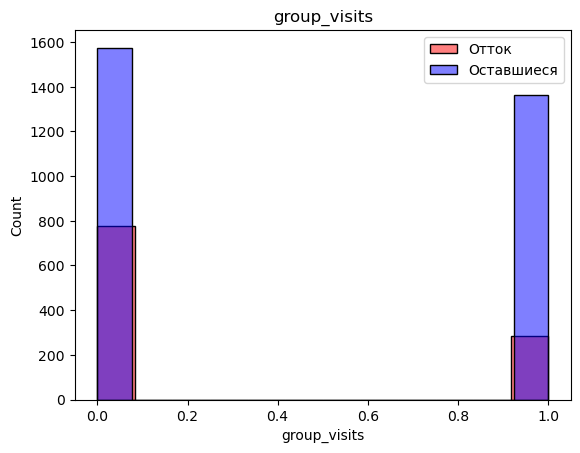

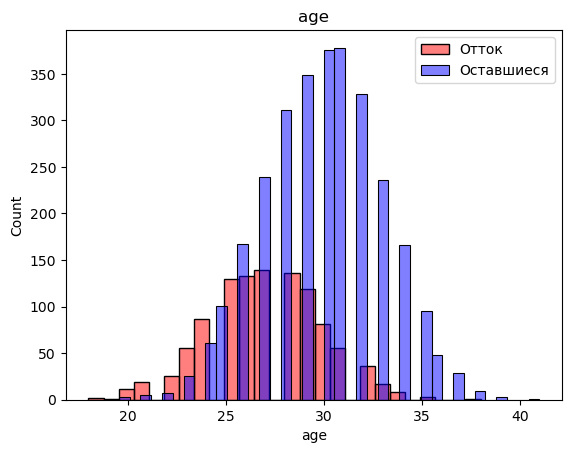

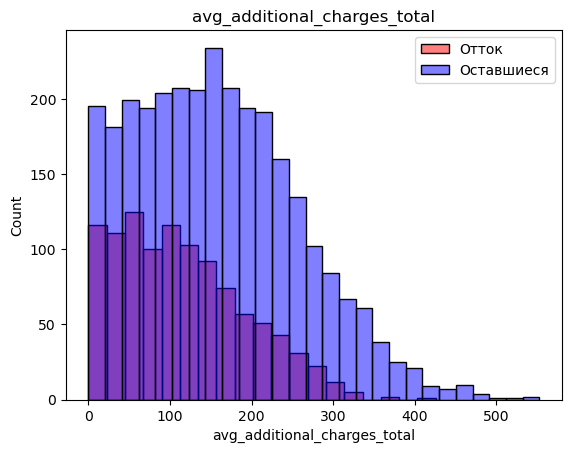

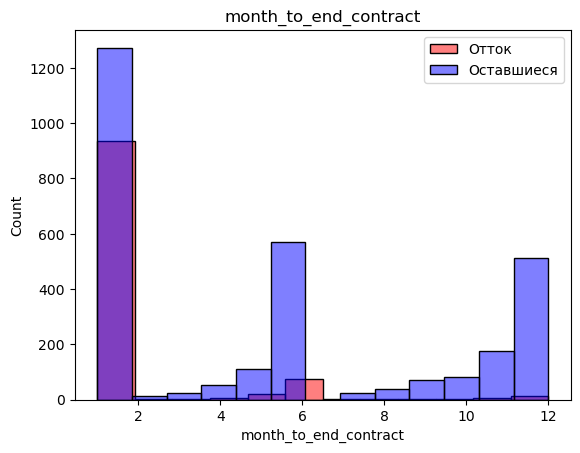

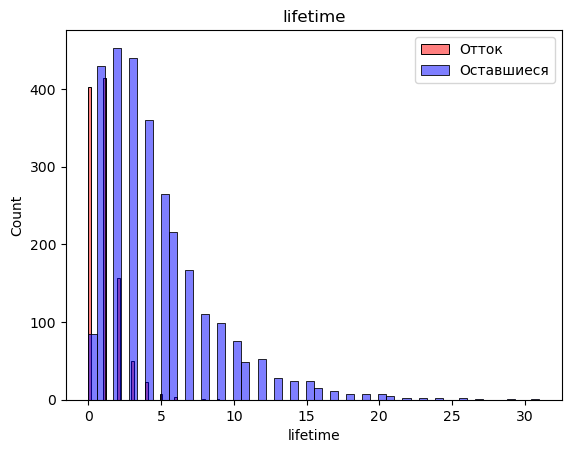

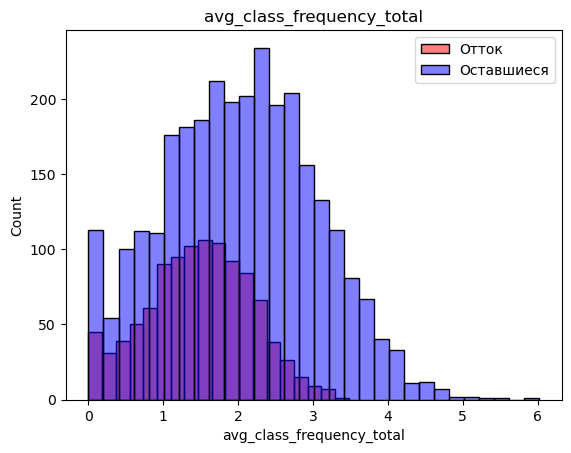

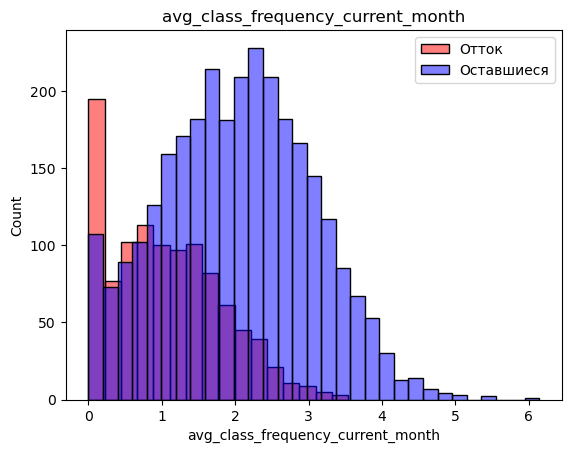

In [11]:
for i in data.drop('churn', axis = 1).columns:
    sns.histplot(data[data['churn'] == 1][i], color='red', alpha=0.5, label='Отток')
    sns.histplot(data[data['churn'] == 0][i], color = 'blue', alpha=0.5, label='Оставшиеся')
    plt.legend()
    plt.title(i)
    plt.show()

Графики в целом подтверждают выводы, отмеченные в прошлом пункте. Можно также отметить, что бросивших крайне мало в  вовзрастной группе 30+ лет. Есть незначительная группа людей, ушедшая из зала, имея на руках абонемент на 6 месяцев.

## Построение модели прогнозирования оттока клиентов

### Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [15]:
X = data.drop(columns=['churn'])
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [16]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [17]:
print('Метрики модели логистической регрессии:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.3f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.3f}'.format(recall_score(y_test, lr_predictions)))

print()
print('Метрики модели случайного леса:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.3f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.3f}'.format(recall_score(y_test, rf_predictions)))


Метрики модели логистической регрессии:
Accuracy: 0.922
Precision: 0.854
Recall: 0.828

Метрики модели случайного леса:
Accuracy: 0.916
Precision: 0.839
Recall: 0.818


Метрики модели логистической регрессии выше, поэтому остановимся на ней.

## Кластеризация клиентов

### Стандартизируем данные

In [16]:
sс = data.drop(['churn'], axis=1)
sc = StandardScaler()
X_sc = sc.fit_transform(data)
linked = linkage(X_sc, method = 'ward') 

### Строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем дендрограмму. 

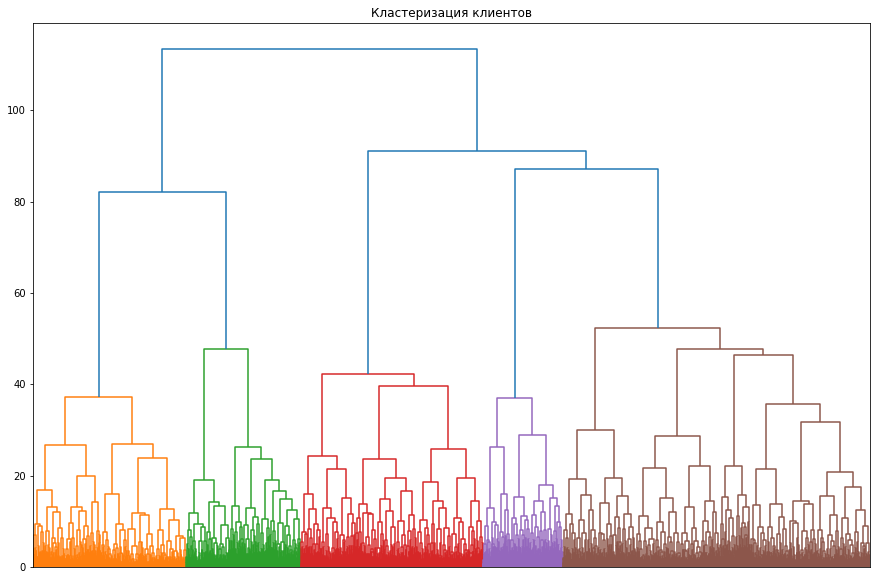

In [17]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Кластеризация клиентов')
plt.show()

### Обучаем модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов. 

In [18]:
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(X_sc) 

### Рассматриваем средние значения признаков для кластеров

In [19]:
data['cluster'] = labels
data.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.503676,0.492829,0.507917,0.521186,0.518895
near_location,0.000000,0.936115,1.000000,0.996610,0.968023
partner,0.459559,0.764016,0.323995,0.282203,0.744186
promo_friends,0.075368,0.534550,0.213155,0.208475,0.526163
phone,0.917279,0.919166,0.903776,0.904237,0.873547
contract_period,2.069853,10.447197,1.546894,1.882203,8.859012
group_visits,0.211397,0.516297,0.287454,0.452542,0.534884
age,28.522059,29.962190,26.926918,30.237288,29.728198
avg_additional_charges_total,132.741216,161.853561,113.173051,157.988625,162.907495
month_to_end_contract,1.950368,9.477184,1.500609,1.794915,8.155523


Выделили 5 кластеров. Из них: 

Первый кластер (0) - уровень оттока составляет 45% (примерно половина). Люди живут далеко от зала, пришли в зал не по акции. 46% из них являются сотрудниками компании-партнёра клуба. Остальные показатели достаточно средние. 

Второй кластер (1) - уровень оттока минимален. Люди живут рядом, являются сотрудниками компании-партнёра клуба. Они давно ходят в зал (больше 4 месяцев), тратят много денег на доп.услуги, их абонемент действует еще больше 10 месяцев. Половина ходит на групповые занятия. В среднем, занимаются спортом больше 2 раз в неделю. 

Третий кластер (2) - уровень оттока максимален. Сюда входят люди, которые живут рядом с залом. До завершения абонементов в среднем остается около 1.5 месяцев. Тратят меньше всех на допуслуги. "Лайфтайм" составляет всего 1 месяц. 

Четвертый кластер (3) - уровень оттока минимален. Средний возраст - более 30 лет. При этом до завершения абонемента осталось меньше 2 месяцев. Остальные показатели приближены к остальным кластерам. 

Пятый кластер(4) - уровень оттока минимален. Больше всех тратят на допуслуги. Ходят в зал реже всех - менее 1 раза в неделю. 

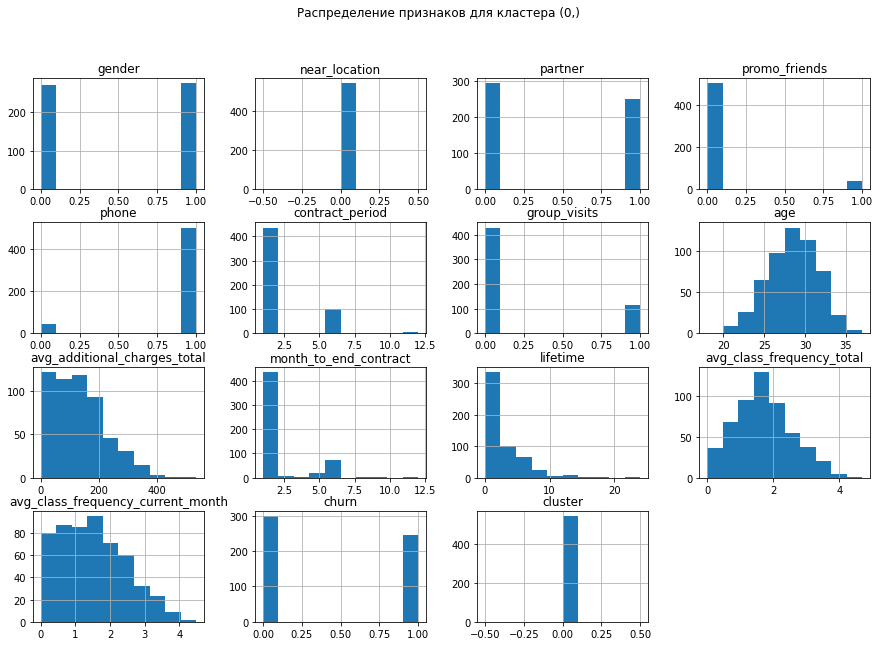

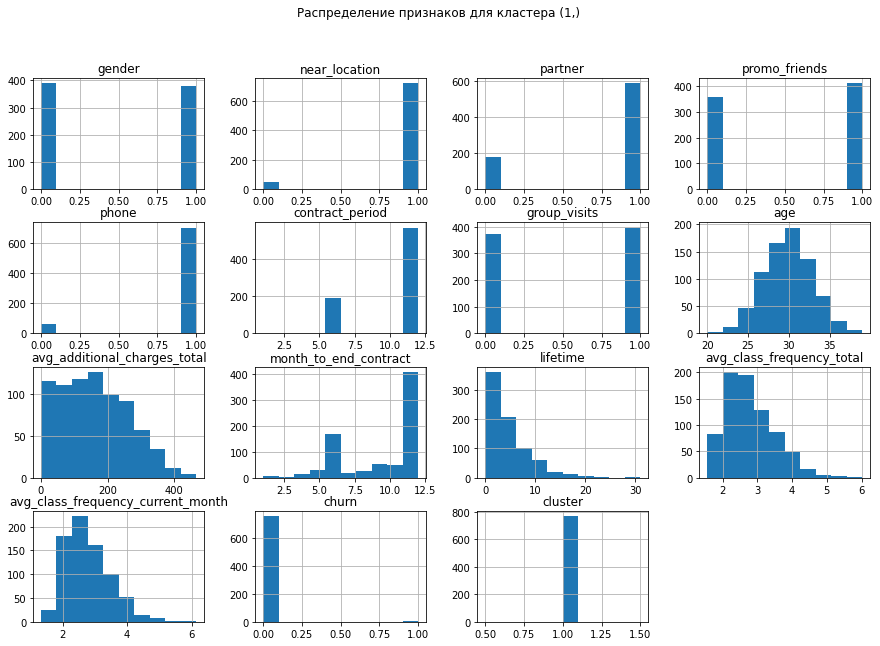

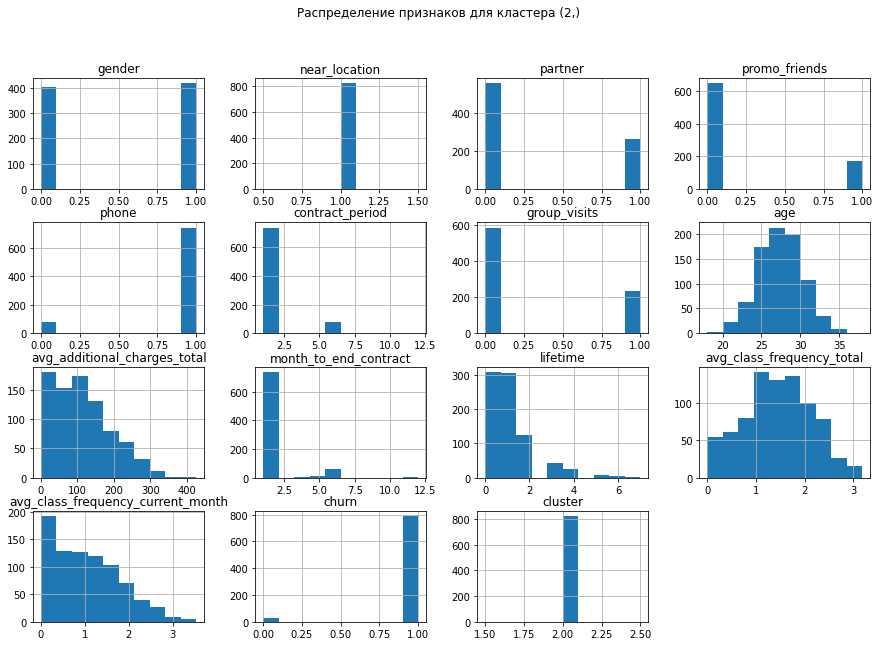

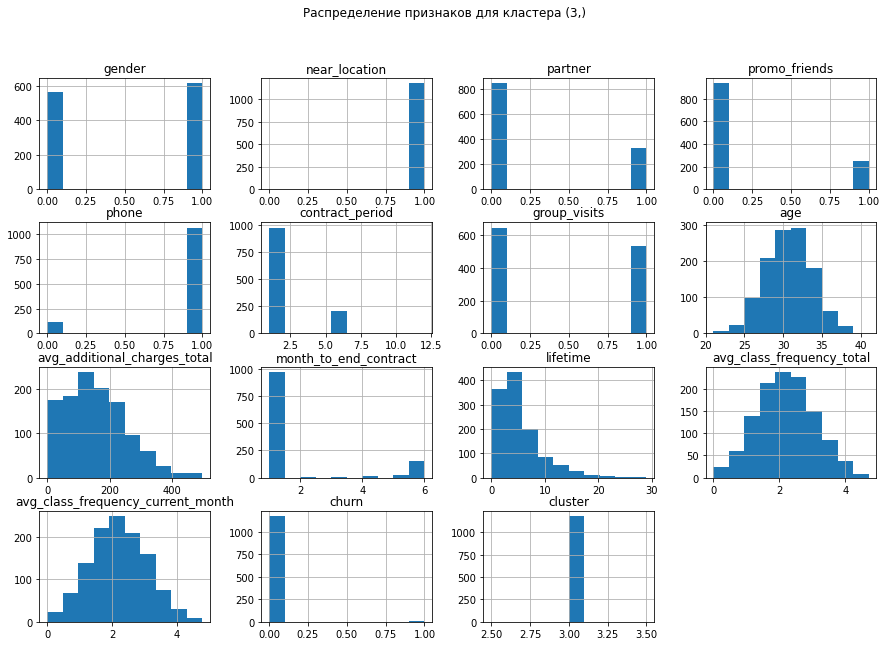

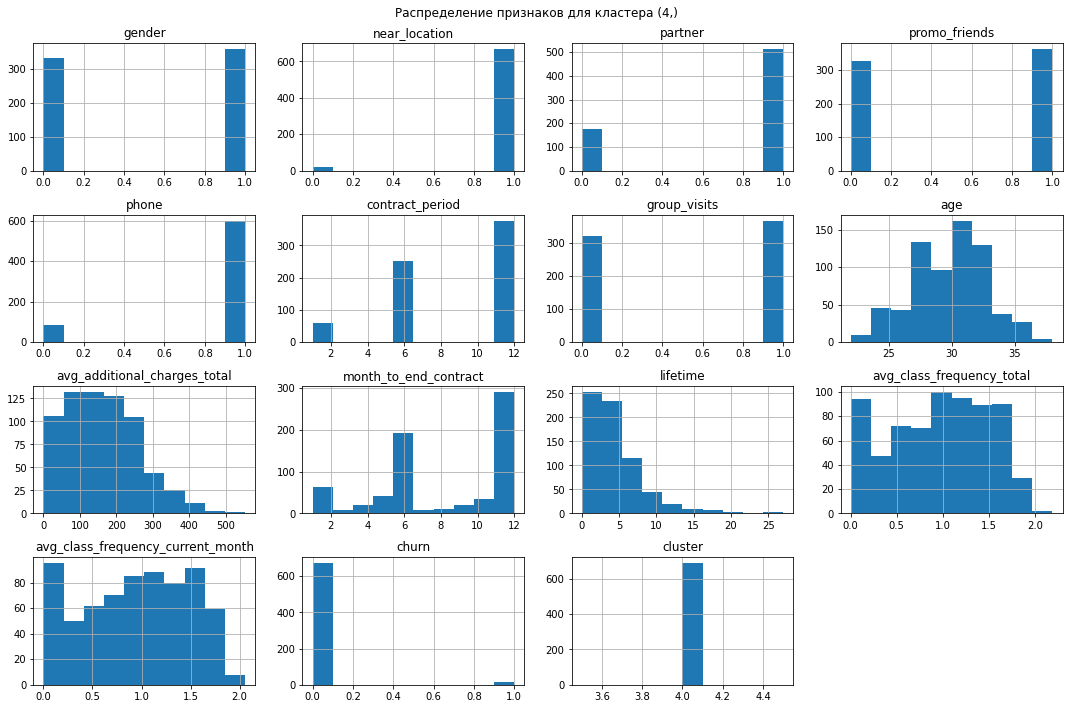

In [20]:
for i in zip([0, 1, 2, 3, 4]):
    data[data['cluster']==i].hist(figsize=(15,10))
    plt.suptitle('Распределение признаков для кластера {}'.format(i))

plt.tight_layout()
plt.show()

Выводы по кластерам схожи - можно добавить, что в третий кластер входят самые молодые спортсмены. Во всех пяти кластерах распределение по полу примерно равное. 

### Для каждого полученного кластера посчитайте долю оттока (методом groupby()).

In [21]:
churn_by_cluster = data.groupby('cluster')['churn'].mean()
churn_by_cluster

cluster
0    0.450368
1    0.007823
2    0.961023
3    0.003390
4    0.024709
Name: churn, dtype: float64

Как было указано выше, третий кластер практически полностью состоит из тех, кто покинул спортзал. Второй, четвертый и пятый, наоборот, из тех, кто остался. В первом - примерно наполовину. 

## Сформулировать выводы и сделать базовые рекомендации по работе с клиентами

1. На отток клиентов не влияет их пол, оставили ли они свой контактный номер или нет. Лояльные пользователи чаще живут ближе, являются сотрудниками компании-партнера клуба, используют промокоды от друзей при первом посещении, посещают групповые занятия, тратят больше денег на другие услуги, чаще посещают спортзал. 

2. Среднестатистический пользователь фитнес-зала - в 84% случаях живет неподалеку, в 48% случаях является сотрудником компании-партнёра клуба, в 30% спользовал промо-код от знакомого при оплате первого абонемента, в 90% оставил свой контактный телефон, оплатил абонемент на 4.6 месяцев, ему 29 лет, до конца абонемента осталось 4.3 месяца, посещает зал в течение 3.7 месяцев, покинул спортзал в этом месяце в 27% случаях.
3. Сотрудники компании-партнёра клуба более лояльны и реже уходят из зала.  
4. При построении модели прогнозирования оттока клиентов использовалась модель логистической регрессии. Выделили 5 кластеров. Исходя из их анализа, можно выделить следующие рекомендации по работе с клиентами: 
    * Сделать упор на жителей, проживающих рядом со спортзалом. Возможно, провести рекламную кампанию. 
    * Организовать более действенную реферальную программу. Предлагать клиентам скидка на допуслуги фитнес-зала, привлекать их групповыми занятиями. 
    * При работе с клиентами сделать акцент на возрастной группе 28+ лет. Продолжать работать с клиентами, которые посещают спортзал 4+ месяцев. 